In [51]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [136]:
class CommNet:
    
    def __init__(self, sess, N, J, embedding_size = 128, lr = 1e-3, training_mode = 'supervised', alpha = 0.03):
        
        self.N = N
        self.J = J
        self.embedding_size = embedding_size
        
        self.build_controler()
        
        self.training_mode = training_mode
        
        if training_mode == 'supervised':
            self.build_supervised()
            with tf.variable_scope('Supervised_optimizer'):
                self.train_op = tf.train.AdamOptimizer(lr).minimize(self.supervised_loss)
                
        elif training_mode == 'reinforce':
            self.alpha = 0.03
            self.build_reinforce()
            with tf.variable_scope('Reinforce_optimizer'):
                self.train_op =  tf.train.RMSPropOptimizer(lr).minimize(self.reinforce_loss)
            
        else:
            raise(ValueError("Unknown training mode: %s" % training_mode))
        
        print("All variables")
        for var in tf.global_variables():
            print(var)
            
        
        self.sess = sess
        self.sess.run(tf.global_variables_initializer())
        
    def encode(self, inputs):
        
        with tf.variable_scope('Encoder'):
        
            self.identity_embeddings = tf.get_variable("identity_embeddings",
                                             [self.N, self.embedding_size])
            
            self.embedded_identities = tf.nn.embedding_lookup(self.identity_embeddings, inputs)
        
            
        return tf.unstack(self.embedded_identities, axis = 1)
    
    def build_f(self, name, h, c, h0 = None):
        
        with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
            
            if h0 is not None:
            
                b1 = tf.get_variable('b1', shape = (1, self.embedding_size))
                W1 = tf.get_variable('W1', shape = (3 * self.embedding_size,
                                                  self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (self.embedding_size,
                                                  self.embedding_size))
                
                concat = tf.concat([h, c, h0], axis = 1)
            
            else:
                b1 = tf.get_variable('b1', shape = (1, self.embedding_size))
                
                W1 = tf.get_variable('W1', shape = (self.embedding_size,
                                                  self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (self.embedding_size,
                                                  self.embedding_size))
                
                concat = h
            
            b2 = tf.get_variable('b2', shape = (1, self.embedding_size))
            
            dense1 =tf.nn.relu(tf.einsum("ij,jk->ik", concat, W1) + b1)
            dense2 = tf.nn.relu(tf.einsum("ij,jk->ik", dense1, W2) + b2)
            
            return dense2
        
    def decode(self, h):
        
        with tf.variable_scope('Decoder', reuse = tf.AUTO_REUSE):
            
            W = tf.get_variable('W', shape = (self.embedding_size,
                                                  self.J))
            
            b = tf.get_variable('b', shape = (1, self.J))
            
            policy_logit = tf.einsum("ij,jk->ik", h, W) + b
        
            return policy_logit
    
    
    def communicate(self, h_seq):
        
        return tf.add_n(h_seq) / (self.J - 1)
    
    def sample_actions(self, policy_logit):
        
        action = tf.multinomial(policy_logit, num_samples = 1)
        
        return action
    
        
    def build_controler(self):
        
        self.inputs = tf.placeholder(tf.int32, shape = (None, self.J))
        
        h0_seq = self.encode(self.inputs)
        #c0_seq = [self.communicate([h0_seq[j] for j in range(self.J) if j != i]) for i in range(self.J)]
        
        h1_seq = [self.build_f("Comm_step_1", h0_seq[j], None, None) for j in range(self.J)]
        c1_seq = [self.communicate([h1_seq[j] for j in range(self.J) if j != i]) for i in range(self.J)]
        
        h2_seq = [self.build_f("Comm_step_2", h1_seq[j], c1_seq[j], h0_seq[j]) for j in range(self.J)]
        
        self.layers = {'h0_seq': h0_seq, 'h1_seq': h1_seq, 'c1_seq':c1_seq, 'h2_seq': h2_seq}
        
        
        self.policy_logit_seq = [self.decode(h2) for h2 in h2_seq]
        
        self.proba_seq = [tf.nn.softmax(policy_logit, axis = 1) for policy_logit in self.policy_logit_seq]
        
        self.action_seq = [self.sample_actions(policy_logit) for policy_logit in self.policy_logit_seq]
        
        self.one_hot_action_seq = [tf.one_hot(action, depth = self.J) for action in self.action_seq]
        
        
        
    def build_supervised(self):
        
        assert self.training_mode == 'supervised', 'Wrong training mode'
        
        self.targets = tf.placeholder(tf.int32, shape = (None, self.J))
        unstacked_targets = tf.unstack(self.targets, axis = 1)
        
        supervised_loss_seq = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_targets[j],
                                                                                   logits=self.policy_logit_seq[j])
                                    for j in range(self.J)]
        
        self.supervised_loss = tf.reduce_mean(supervised_loss_seq)
        
        
    def supervised_train(self, X, y, val_X, val_y, env, batch_size = 32, epochs = 1):
        
        assert self.training_mode == 'supervised', 'Wrong training mode'
        
        n = X.shape[0]
        
        val_n = val_X.shape[0]
        
        data_inds = np.array(range(n))
        for ep in range(1, epochs + 1):
            np.random.shuffle(data_inds)
            supervised_loss_sum = 0
            reward_sum = 0
            for i in tqdm_notebook(range(0, n, batch_size), "Epoch: %d" % ep):
                inds_batch = data_inds[i:i+batch_size]
                X_batch = X[inds_batch]
                y_batch = y[inds_batch]
                _, supervised_loss, one_hot_action_seq = sess.run([self.train_op, self.supervised_loss, self.one_hot_action_seq], feed_dict={self.inputs: X_batch, self.targets: y_batch})
                supervised_loss_sum += supervised_loss * batch_size
                reward_sum += env.get_reward(one_hot_action_seq)
            
            print("loss = %f" % (supervised_loss_sum / n))
            print("reward = %f" % (reward_sum / n))
            print()
            
            val_supervised_loss, val_one_hot_action_seq = sess.run([self.supervised_loss, self.one_hot_action_seq], feed_dict={self.inputs: val_X, self.targets: val_y})
            print('val loss = %f' % (val_supervised_loss))
            print('val reward = %f' % (env.get_reward(val_one_hot_action_seq) / val_n))
            

    def build_reinforce(self):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        
        self.state_q_val_seq = tf.placeholder(tf.float32, shape = (None, self.J, self.J))
        
        self.reward_sum_values = tf.placeholder(tf.float32, shape = (None,))
        self.advantage_values = tf.placeholder(tf.float32, shape = (None,))
  
        
        self.action_taken = tf.placeholder(tf.int32, shape = (None, self.J))
        unstacked_action_taken = tf.unstack(self.action_taken, axis = 1)
        
        self.neg_log_p_seq = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_action_taken[j],
                                                    logits=self.policy_logit_seq[j]) for j in range(self.J)]
        
        neg_log_p_sums = tf.reduce_sum(self.neg_log_p_seq, axis = 0)
        
        
        stacked_proba_seq = tf.stack(self.proba_seq, axis = 1)
        
        baseline = tf.einsum('ijk, ijk-> ij', self.state_q_val_seq, stacked_proba_seq)
        baseline = tf.reduce_mean(baseline, axis = 1)
        
        #surrogate loss (- dtheta)
        advantage = self.reward_sum_values - baseline
    
        self.reinforce_loss =  tf.multiply(neg_log_p_sums, self.advantage_values)
        self.reinforce_loss += self.alpha * tf.square(advantage)
        self.reinforce_loss = tf.reduce_sum(self.reinforce_loss, axis = 0)
        
        
    def take_action(self, state):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        action_seq, proba_seq = self.sess.run([self.action_seq, self.proba_seq], {self.inputs: [state]})
        
        return [a[0,0] for a in action_seq], np.array(proba_seq)
    
    def reinforce_train(self, env, n_episodes, T):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        
        history = {'reward' : [],  'loss': []}
        
        q_val = np.zeros((self.N, self.J))
    
        
        for _ in tqdm_notebook(range(n_episodes), "REINFORCE"):
            
            
            state_seq, action_seq, reward_seq, proba_seq = policy_rollout(T, env, self)
            episode_len = reward_seq.shape[0]
            
            history['reward'].append(np.mean(reward_seq))
        
            state_q_val_seq = np.array([q_val[state] for state in state_seq])
            
            baseline = np.einsum('ijk, ijk-> ij', state_q_val_seq, proba_seq)
            
            baseline = baseline.mean(axis = 1)
            
            reward_sum_values = np.array([reward_seq[t:].sum() for t in range(episode_len)])
            advantage_values = np.array([reward_sum_values[t] - baseline[t] for t in range(episode_len)])          
            
            
            feed_dict = {}
            feed_dict[self.inputs] = state_seq
            feed_dict[self.state_q_val_seq] = state_q_val_seq
            feed_dict[self.reward_sum_values] = reward_sum_values
            feed_dict[self.advantage_values] = advantage_values
            feed_dict[self.action_taken] = action_seq
            
            _, loss = self.sess.run([self.train_op, self.reinforce_loss], feed_dict = feed_dict)
            
            history['loss'].append(loss)
            
            # udpate_q_val
            q_reward_sum = np.zeros((self.N, self.J))
            q_state_action_count = np.zeros((self.N, self.J))
            for i in range(episode_len):
                
                state = state_seq[i]
                action = action_seq[i]
                
                cummul_reward = reward_seq[i:].sum()
                q_state_action_count[state, action] += 1
                q_reward_sum[state, action] += cummul_reward
            
            q_val = 0.99 * q_val + 0.1 * q_reward_sum/np.maximum(1,q_state_action_count)
            
            
        return history, q_val
            
            
            
            
            
            
            
        

In [130]:
class LeverEnv:
    
    def __init__(self, N, J):
        
        self.J = J
        self.N = N
        
    def reset(self):
        
        state = np.random.choice(self.N, size = self.J, replace = False)
        
        terminal_state = False
        
        return state, terminal_state
    
    def get_reward(self, one_hot_action_seq):        
        
        reward = np.sum(np.sum(one_hot_action_seq, axis = 0) > 0) /self.J
        
        return reward
        
    def step(self, state, action):
        
        next_state = np.random.choice(self.N, size = self.J, replace = False)
        
        one_hot_action_seq = np.zeros((self.J, self.J))
        one_hot_action_seq[range(self.J), action] = 1
        reward = self.get_reward(one_hot_action_seq)
        
        terminal_state = False
        
        return next_state, reward, terminal_state
        

In [131]:
# data generation for supervised learning
def generate_data(n, N, J):
    
    X = np.empty((n, J), dtype = int)
    y= np.empty((n,J), dtype = int)
    
    for i in range(n):
        
        X[i] = np.random.choice(N, size = J, replace = False)
        sorted_args = np.argsort(X[i])
        y[i] = np.argsort(sorted_args)
        
    return X, y

In [132]:
# episode generation for reinforcement learning
def policy_rollout(T, env, agent):
    
    state_seq = []
    action_seq = []
    reward_seq = []
    proba_seq = []
    
    
    state, terminal_state = env.reset()
    
    t = 0
    
    while not terminal_state and t < T:
        t +=1
        
        state_seq.append(state)
        action, proba = agent.take_action(state)
        
        state, reward, terminal_state = env.step(state, action)
        
        
        action_seq.append(action)
        reward_seq.append(reward)
        proba_seq.append(proba)
        
    return np.array(state_seq), np.array(action_seq), np.array(reward_seq), np.squeeze(np.array(proba_seq))

In [137]:
N = 500
J = 5

In [124]:
batch_size = 32
n = batch_size * 1000
X, y = generate_data(n, N, J)
val_X, val_y = generate_data(500, N, J)

In [140]:
tf.reset_default_graph()
with tf.Session() as sess:
    commNet = CommNet(sess, N, J, lr = 1e-3, embedding_size= 128, training_mode = 'reinforce', alpha = 0.03)
    env = LeverEnv(N, J)
    
    #commNet.supervised_train(X, y, val_X, val_y, env, batch_size = batch_size, epochs = 1)
    #rv = sess.run([commNet.embedded_identities, commNet.identity_embeddings, commNet.layers], feed_dict = {commNet.inputs: val_X[0:2], commNet.targets: val_y[0:2]})
    
    history, q_val = commNet.reinforce_train(env, n_episodes = 3000, T =64)
    state_seq, action_seq, reward_seq, proba_seq = policy_rollout(T = 32, env = env, agent = commNet)

All variables
<tf.Variable 'Encoder/identity_embeddings:0' shape=(500, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/b1:0' shape=(1, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/W1:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/W2:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/b2:0' shape=(1, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/b1:0' shape=(1, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/W1:0' shape=(384, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/W2:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/b2:0' shape=(1, 128) dtype=float32_ref>
<tf.Variable 'Decoder/W:0' shape=(128, 5) dtype=float32_ref>
<tf.Variable 'Decoder/b:0' shape=(1, 5) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Encoder/identity_embeddings/RMSProp:0' shape=(500, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Encoder/identity_embeddings/RMSProp_1:0' shape=(500, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optim

HBox(children=(IntProgress(value=0, description='REINFORCE', max=3000, style=ProgressStyle(description_width='initial')), HTML(value='')))

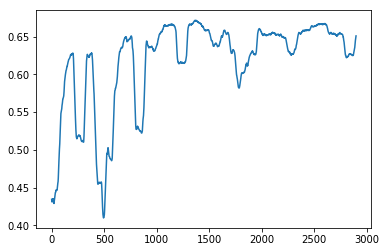

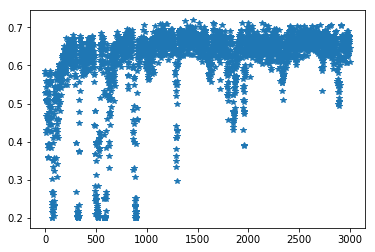

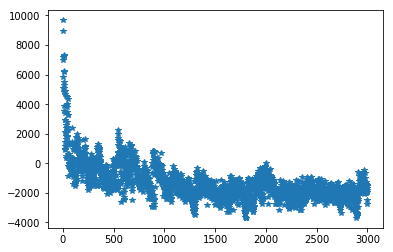

In [141]:
W = 100
plt.plot(np.convolve(history['reward'], np.ones(W), mode= 'valid')/W)
plt.show()
plt.plot(history['reward'], '*')
plt.show()
plt.plot(history['loss'], '*')
plt.show()

In [122]:
for x in proba_seq:
    print()
    for xx in x:
        print(xx)


[0.22577909 0.26917762 0.21279874 0.16583364 0.12641096]
[0.22016849 0.22563423 0.22212386 0.19095235 0.14112104]
[0.21960501 0.23955436 0.22702406 0.1854479  0.12836868]
[0.23304532 0.20993459 0.22559714 0.1791272  0.15229584]
[0.20872119 0.25417063 0.2264204  0.18819685 0.12249094]

[0.21246645 0.20228745 0.23133822 0.20866685 0.145241  ]
[0.22078106 0.24104035 0.21198149 0.18721826 0.13897899]
[0.22285442 0.24080707 0.21916117 0.18383345 0.13334392]
[0.21217397 0.23280925 0.22768702 0.18952763 0.13780206]
[0.19502863 0.266822   0.22554079 0.19426489 0.11834362]

[0.21161614 0.22226155 0.22272208 0.20031306 0.14308715]
[0.21610449 0.21933357 0.22805688 0.19413775 0.14236726]
[0.21205838 0.24951085 0.22500771 0.18818292 0.12524009]
[0.21903999 0.209828   0.22463156 0.1948897  0.15161072]
[0.23773776 0.18132898 0.2302288  0.18018381 0.1705207 ]

[0.22067125 0.21549195 0.22589959 0.18399791 0.15393928]
[0.21357127 0.24210793 0.22301947 0.1944984  0.12680286]
[0.19097054 0.26365468 0.22

[0.2242059  0.21298023 0.22037363 0.19078308 0.1516572 ]
[0.20396619 0.25523153 0.22252809 0.1957742  0.12249994]

[0.21333747 0.20636319 0.22664948 0.20545466 0.14819522]
[0.20151992 0.28966737 0.21825255 0.17881928 0.11174096]
[0.21180518 0.22751749 0.22716019 0.19526762 0.13824949]
[0.21623227 0.2227236  0.22569863 0.19739991 0.1379456 ]
[0.22215946 0.23508789 0.21731377 0.182012   0.14342684]

[0.2152606  0.24317682 0.22295639 0.1923544  0.12625185]
[0.21425165 0.24918205 0.21947832 0.18672948 0.13035853]
[0.21657386 0.20686142 0.22799271 0.20631416 0.14225787]
[0.2198012  0.18842211 0.22526214 0.20336626 0.16314822]
[0.21362345 0.24957725 0.2227816  0.18606177 0.12795587]

[0.20879415 0.28129983 0.21555294 0.18973482 0.10461818]
[0.20693961 0.2928036  0.20534395 0.18752693 0.10738587]
[0.22713229 0.21451686 0.22164981 0.18781193 0.14888912]
[0.22520345 0.18221782 0.22888982 0.19892257 0.16476624]
[0.21625517 0.23595075 0.22402875 0.18682045 0.13694482]


In [24]:
print(state_seq)
print(action_seq)
print(reward_seq)
print(proba_seq)

[[11  2 12 10  7]
 [ 3 13  7  8  2]
 [10 17  9 16  8]
 [19  9  7  1 14]
 [ 8 18  4 13 10]
 [12 13  3  4  6]
 [ 8  5  2 18 15]
 [ 3  2 12 17  1]
 [12  8 15 13 14]
 [18 10 12 17 11]
 [ 6 17 13  5 10]
 [ 5 10 13 17  3]
 [18 14 16 19  0]
 [15  1 14 19  6]
 [ 2  8  5  6  1]
 [ 6  5 16  7  9]
 [ 6  9  7 16  2]
 [ 3 10 13 11  4]
 [17  9  0 15  7]
 [16  8  9 11  5]
 [10 15 13  1  2]
 [ 6  3  8  4 19]
 [14 18 15  0 19]
 [19  2 16 18  1]
 [ 9 13 15  8  1]
 [14  9 15 11  2]
 [ 2  3  5 13 10]
 [13 11 14  5  0]
 [ 7  0 10 11  1]
 [15  8  3  5 13]
 [10 13  7  1 16]
 [ 4 15 13  5 12]]
[[0 4 3 3 0]
 [4 4 4 4 0]
 [4 4 4 4 2]
 [4 4 0 1 0]
 [0 4 1 1 0]
 [1 0 0 0 3]
 [1 4 4 0 2]
 [0 3 3 1 2]
 [4 3 0 4 4]
 [0 2 0 3 0]
 [1 0 4 0 1]
 [0 0 3 0 3]
 [1 3 4 3 2]
 [0 0 4 4 0]
 [2 4 0 0 0]
 [0 1 0 0 1]
 [0 1 1 4 4]
 [0 2 1 1 0]
 [0 4 1 4 2]
 [0 1 2 3 4]
 [2 1 4 3 4]
 [3 2 2 3 1]
 [1 0 3 4 0]
 [2 0 4 0 4]
 [3 2 3 3 4]
 [4 3 4 4 0]
 [0 2 4 0 1]
 [4 3 4 0 3]
 [3 1 0 0 4]
 [0 2 0 4 0]
 [1 0 3 0 4]
 [4 2 0 2 3]]
[0.6 0

  [0.30450714 0.14674391 0.12129466 0.1536208  0.27383348]]]


In [19]:
q_val.mean(axis = 1)

array([28.52549005, 26.83711791, 24.02530871, 23.24229658, 27.23337449,
       28.84543439, 24.33568897, 26.26860505, 25.96140667, 27.07182011,
       21.27360903, 29.08008743, 23.79652492, 25.50486198, 22.5891042 ,
       26.65870543, 24.52190399, 25.87027532, 26.28681852, 25.14499152,
       25.13469512, 22.16957391, 29.72034937, 24.85397709, 27.42722795,
       25.46531251, 24.02437809, 26.12751629, 25.73490067, 24.65851013,
       27.28950795, 22.43409433, 26.12270209, 26.46135845, 22.69748478,
       31.30909772, 23.00024317, 28.33341599, 27.39134367, 25.81406683,
       28.04007545, 26.19277877, 25.65760425, 25.70790826, 26.63369052,
       26.50099764, 27.79163387, 23.14206769, 25.28080371, 22.75290376,
       28.23282662, 24.34427645, 24.99055153, 23.67124444, 27.0354319 ,
       24.34679755, 29.03618817, 25.9935099 , 27.42412429, 21.0344153 ,
       27.16590735, 27.68422711, 23.80210265, 27.27962052, 27.4083592 ,
       27.06932029, 25.20328026, 25.09378981, 27.85210011, 30.00